# Plano de Avaliação - Dell Academy
### Processamento de Linguagem Natural
#### Stefane Adna dos Santos


#### Importando as bibliotecas e o dataset

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict
from sklearn import linear_model as lm
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, MultinomialNB,CategoricalNB,ComplementNB,GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import spacy
import re
import nltk
from nltk import word_tokenize, download
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from keras.utils import np_utils
from sklearn import metrics
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report,cohen_kappa_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Perceptron
from sklearn.ensemble import VotingClassifier,BaggingClassifier
from sklearn.cluster import KMeans
from wordcloud import WordCloud
from collections import Counter
from itertools import chain
from spacy import displacy

https://cienciaenegocios.com/processamento-de-linguagem-natural-nlp/
https://medium.com/@ageitgey/natural-language-processing-is-fun-9a0bff37854e
https://carlos-bonfim.medium.com/machine-learning-e-processamento-de-linguagem-natural-pln-com-modelos-lineares-d5aaaaf0efa5
https://operdata.com.br/blog/pln-processamento-de-linguagem-natural/

In [2]:
download('punkt')
download('stopwords')
download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\STEFA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\STEFA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\STEFA\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

##### Importando o Dataset

In [3]:
df_train = pd.read_csv("dataset/train.csv")
df_test = pd.read_csv("dataset/test.csv")

Unindo os dataset de treino e teste para facilitar a etapa de limpeza

In [4]:
df = pd.concat([df_train,df_test])

In [5]:
df

,text,sentiment
0,"Now, I won't deny that when I purchased this o...",neg
1,"The saddest thing about this ""tribute"" is that...",neg
2,Last night I decided to watch the prequel or s...,neg
3,I have to admit that i liked the first half of...,neg
4,I was not impressed about this film especially...,neg
...,...,...
24995,"For one thing, he produced this movie. It has ...",neg
24996,The title comes from an alteration an adolesce...,pos
24997,Christopher Nolan's first film is a 'no budget...,pos
24998,The story is shortly about the faith-lacking b...,neg


Categorizando a coluna de sentimentos para o tipo númerico.

    0: Sentimento negativo

    1: Sentimento Positivo

In [6]:
def sentiment_categorization(df):
    df.loc[df.sentiment=='neg','sentiment_cate'] = 0
    df.loc[df.sentiment=='pos','sentiment_cate'] = 1
    return df

df = sentiment_categorization(df)

Analisando os dtypes das colunas

In [7]:
df.dtypes

text               object
sentiment          object
sentiment_cate    float64
dtype: object

In [8]:
df.sample(5)

,text,sentiment,sentiment_cate
275,This may not be the most exiting or incredible...,pos,1.0
17635,"Two houses, one street, one phone booth, one c...",neg,0.0
18166,This is an interesting true story of Archie Gr...,pos,1.0
6496,"""Classe tous risques"" feels like the granddadd...",pos,1.0
15216,Bonfires of the Vanities is a film drenched in...,neg,0.0


#### Word Cloud

In [10]:
all_word = ' '.join([text for text in df.text])

In [13]:
wc = WordCloud(max_words=1000, margin=10, background_color='white',
scale=3, relative_scaling = 0.5, width=500, height=400,
random_state=1).generate(all_word)

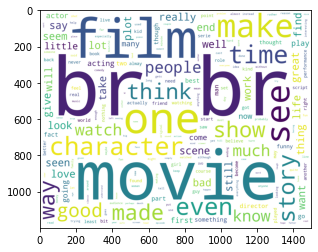

In [14]:
plt.figure()
plt.imshow(wc)
plt.show()

OBS: Um dataset de texto possui dados bem poluidos com simbolos, acentos, tags entre outros. Como visto acima a tag br do html foi identificada como uma das palavras mais frequentes no texto, no entanto ela é inutil para uma predição. Logo se faz necessária a limpeza desses dados, com o intuito de prepará-los para a etapa de classificação.

### Limpeza e Pré-Processamento

#### Normalização
O processo de normalização no Processamento de Linguagem Natural trata de colocar todas as palavras em caixa baixa, retirando os acentos ou cedilha. Isto faz com que os algoritmos de análise não tratem palavras iguais como sendo diferentes apenas por apresentarem a letra inicial como maiúscula, ou um erro de acentuação, por exemplo.

1. Transformar coluna 'text' em list para facilitar a manipulação

In [16]:
df_list = list(df['text'][:3])
df_list[0]

"Now, I won't deny that when I purchased this off eBay, I had high expectations. This was an incredible out-of-print work from the master of comedy that I so enjoy. However, I was soon to be disappointed. Apologies to those who enjoyed it, but I just found the Compleat Al to be very difficult to watch. I got a few smiles, sure, but the majority of the funny came from the music videos (which I've got on DVD) and the rest was basically filler. You could tell that this was not Al's greatest video achievement (that honor goes to UHF). Honestly, I doubt if this will ever make the jump to DVD, so if you're an ultra-hardcore Al fan and just HAVE to own everything, buy the tape off eBay. Just don't pay too much for it."

2. Remover caracteres desnecessários e transformar todos os caracteres para minusculo

In [17]:
def pre_processing(textos):
    caracteres_1 = re.compile("[.;:!\'?@,\"()\[\]]")
    caracteres_2 = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
    caracteres_3 = re.compile('[^A-Za-z0-9\s]+')

    textos = [caracteres_1.sub("", texto) for texto in textos]
    textos = [caracteres_2.sub(" ", texto.lower()) for texto in textos]
    textos = [caracteres_3.sub("", texto) for texto in textos]
    
    return textos

df_processed = pre_processing(df_list)

In [18]:
df_processed[0]

'now i wont deny that when i purchased this off ebay i had high expectations this was an incredible out of print work from the master of comedy that i so enjoy however i was soon to be disappointed apologies to those who enjoyed it but i just found the compleat al to be very difficult to watch i got a few smiles sure but the majority of the funny came from the music videos which ive got on dvd and the rest was basically filler you could tell that this was not als greatest video achievement that honor goes to uhf honestly i doubt if this will ever make the jump to dvd so if youre an ultra hardcore al fan and just have to own everything buy the tape off ebay just dont pay too much for it'

Como visto acima, a etapa de limpesa remove caracteres especiais, tagas html, entre outros.

#### Tokenização

A tokenização quebra a estrutura de um texto em palavras.

><div>
<img src="imgs/tokens.png",width=100, height=50>
</div>


In [19]:
df_tokens = [word_tokenize(text) for text in df_processed]

In [20]:
str(df_tokens[0])

"['now', 'i', 'wont', 'deny', 'that', 'when', 'i', 'purchased', 'this', 'off', 'ebay', 'i', 'had', 'high', 'expectations', 'this', 'was', 'an', 'incredible', 'out', 'of', 'print', 'work', 'from', 'the', 'master', 'of', 'comedy', 'that', 'i', 'so', 'enjoy', 'however', 'i', 'was', 'soon', 'to', 'be', 'disappointed', 'apologies', 'to', 'those', 'who', 'enjoyed', 'it', 'but', 'i', 'just', 'found', 'the', 'compleat', 'al', 'to', 'be', 'very', 'difficult', 'to', 'watch', 'i', 'got', 'a', 'few', 'smiles', 'sure', 'but', 'the', 'majority', 'of', 'the', 'funny', 'came', 'from', 'the', 'music', 'videos', 'which', 'ive', 'got', 'on', 'dvd', 'and', 'the', 'rest', 'was', 'basically', 'filler', 'you', 'could', 'tell', 'that', 'this', 'was', 'not', 'als', 'greatest', 'video', 'achievement', 'that', 'honor', 'goes', 'to', 'uhf', 'honestly', 'i', 'doubt', 'if', 'this', 'will', 'ever', 'make', 'the', 'jump', 'to', 'dvd', 'so', 'if', 'youre', 'an', 'ultra', 'hardcore', 'al', 'fan', 'and', 'just', 'have',

#### Stop words
As stop words são palavras que não adicionam sentido ao texto, pois são usadas para coesão e dar contexto, mas não fazem sentido específico quando olhadas individualmente. Portanto, o processo necessário em análises que usam Processamento de Linguagem Natural é eliminar as palavras vazias (stop words).

In [21]:
stop_words = stopwords.words('english')

In [22]:
df_without_sw = [[token for token in text if token not in stop_words]
                  for text in df_tokens]

In [23]:
print('Tamanho do texto com stop words: '+str(len(df_tokens[0])))
print('Tamanho do texto sem stop words: '+str(len(df_without_sw[0])))

Tamanho do texto com stop words: 140
Tamanho do texto sem stop words: 63


OBS: É notório que um texto ja tem seu tamanho diminuido em mais de 50% só com a remoção das stops words. Isso irá facilitar a etapa de classificação.

#### Lematização
Tem como objetivo reduzir uma palavra à sua forma base e agrupar diferentes formas da mesma palavra. 

    Exemplo: As palavras durmo, dormiu, dormirá... seria lematizada para apenas dormir

In [24]:
lematizer = WordNetLemmatizer()
df_lematizer = [[lematizer.lemmatize(token) for token in text] for text in df_without_sw]

#### Stemização
O termo stemização vem do inglês stemming, e representa o processo de reduzir palavras flexionadas ou derivadas a sua base. Neste processo a tarefa é transformar palavras próximas em uma só, como ficar apenas com o radical dos verbos ou transformar todos os substantivos para o singular.

    Por exemplo: As palavras dormir, dormiu, dormirá... seria stematizada para apenas dorm

Isso ajuda pois diminui o tamanho das palavras, logo torna o processo de classificação mais rapido.

In [25]:
stemization = LancasterStemmer()
df_stemization = [[stemization.stem(token) for token in text] for text in df_lematizer]

Comparação das etapas entre a tokenização, lematização e stematização

In [28]:
print(df_without_sw[1][:5])
print(df_lematizer[1][:5])
print(df_stemization[1][:5])

['saddest', 'thing', 'tribute', 'almost', 'singers']
['saddest', 'thing', 'tribute', 'almost', 'singer']
['saddest', 'thing', 'tribut', 'almost', 'sing']


OBS: Um exemplo é a palavra 'singers' que foi lematizada para 'singer' e stematizada para 'sing'

##### Função para realizar essas etapas em todo o dataset

1. utilizando o NLTK

In [23]:
def processamento_nltk(df):    
    text_processado = list()
    df_processed = pre_processing(df)
    df_processed = [word_tokenize(text) for text in df_processed]
    
    stop_words = stopwords.words('english')
    df_processed = [[token for token in text if token not in stop_words]
                  for text in df_processed]
    
    lematizer = WordNetLemmatizer()
    df_processed = [[lematizer.lemmatize(token) for token in text] for text in df_processed]
    
    stemization = LancasterStemmer()
    df_processed = [[stemization.stem(token) for token in text] for text in df_processed]
    
    for frase in df_processed:
        text_processado.append(' '.join(frase))
        
    return text_processado
    

2. utilizando o spacy

In [24]:
#tokeniza e remove as stop words, salvando o lemma
def processamento_spacy(df):
    df_tokens = list()
    df = pre_processing(df)
    df_processado = list()
    nlp = spacy.load("en_core_web_sm")
    for text in df:
        tokens = list()
        doc = nlp(text)
        for token in doc:
            if(not(token.is_stop)):
                tokens.append(token.lemma_)
        df_tokens.append(tokens)
    
    for frase in df_tokens:
        df_processado.append(' '.join(frase))
    return df_processado

OBS: O spacy não possui a função de stematização

In [25]:
df_list = list(df['text'])
df['text_processed_nltk'] = processamento_nltk(df_list)

In [26]:
df['text_processed_spacy'] = processamento_spacy(df_list)

##### Salva o dataset pré-processado 

In [27]:
#df['text_processed'] = df_processado
#df.to_csv('dataset/df_processado_completo.csv')

In [28]:
df.sample(5)

,text,sentiment,sentiment_cate,text_processed_nltk,text_processed_spacy
16374,This is one of the best movies on the French R...,pos,1.0,on best movy french revolv ev produc person we...,good movie french revolution produce person ve...
1378,Anna Christie (1931)<br /><br />On its own ter...,pos,1.0,ann christie 1931 term vert garbo ann christie...,anna christie 1931 term version garbo anna chr...
9339,Something strange is happening in remote areas...,neg,0.0,someth strange hap remot are arct air forc wea...,strange happen remote area arctic air force we...
7828,The TV show was slow moving and the 'offbeat' ...,neg,0.0,tv show slow mov offb charact sometim irrit mi...,tv slow move offbeat character irritate miracl...
15096,I am assuming that the rave reviews on this pa...,neg,0.0,assum rav review pag peopl nev read book unfor...,assume rave review page people read book un...


#### Analise e Visualização textual

In [13]:
df_train = pd.read_csv("dataset/df_processado_completo.csv")
X = df_train['text_processed_spacy']
y = df_train['sentiment_cate'].to_numpy()

In [14]:
nlp = spacy.load("en_core_web_sm")

In [15]:
df_processado = list(X)

##### Exibe alguns conceitos linguisticos das frases

In [16]:
def conceitos(text):    
    doc = nlp(text)
    df = pd.DataFrame(columns = ['Text', 'Lemma', 'Pos','Dep','Is Stop'])
    for token in doc:
        df=df.append({'Text' : str(token.text) , 'Lemma' : str(token.lemma_), 'Pos' : str(token.pos_),'Dep' : str(token.dep_),'Is Stop' : str(token.is_stop)},ignore_index=True)
    return df

In [17]:
#conceitos(df_processado[0])

##### Mostra as dependencias dentro do texto

In [10]:
text = str(df_train['text'][1])
doc = nlp(text)
displacy.render(doc, style="ent",jupyter=True)

##### Retorna a frequencia de cada palavra dentro do dataframe já limpo e processado

In [18]:
def word_frequency(df):
    words_counts = Counter(chain.from_iterable([text.split(" ") for text in df]))
    words_freq = list(sorted(words_counts.items(), key=lambda x: x[1], reverse=True))
    df_word_frequency = pd.DataFrame(words_freq,columns = ['word', 'frequency'])
    df_word_frequency = df_word_frequency.drop(index=0)
    return df_word_frequency

OBS: Note que existem muitas palavras que só se repetem uma unica vez, ela podem terem sido geradas de nomes de pessoas, siglas, palavras erradas e até abreviações

In [19]:
df_word_frequency = word_frequency(X)
df_word_frequency

,word,frequency
1,movie,102382
2,film,94804
3,nt,67672
4,like,44037
5,good,41177
...,...,...
113592,hoganc,1
113593,haaaa,1
113594,peacemaking,1
113595,centavo,1


##### Cria uma coluna com o Pos de cada palavra. O metodo POS do spacy retorna a classificação gramatical de cada palavra.

In [13]:
def pos(token_frequency):
    pos_completo = list()
    for token in token_frequency:
        pos = list()
        doc = nlp(token)
        for token in doc:
            pos.append(str(token.pos_))
        pos_completo.append(str(pos))
    return pos_completo

df_word_frequency = df_word_frequency.query('frequency>5')
token_frequency = list(df_word_frequency.word)

In [14]:
pos = pos(token_frequency)
df_word_frequency.insert(2, "pos", pos)

In [16]:
df_word_frequency

,word,frequency,pos
1,movie,102382,['NOUN']
2,film,94804,['NOUN']
3,nt,67672,['PART']
4,like,44037,['INTJ']
5,good,41177,['ADJ']
...,...,...,...
29184,azucena,6,['NOUN']
29185,prosatano,6,['NOUN']
29186,catspaw,6,['ADJ']
29187,mathilde,6,['VERB']


##### Top 10 de POS

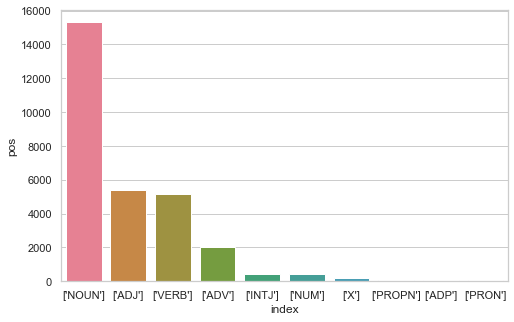

In [29]:
data = df_word_frequency.pos.value_counts().to_frame().reset_index()
data = data.nlargest(10, 'pos')
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8,5))
sns.barplot(x="index",y = "pos", data = data, palette="husl")
plt.show()

In [30]:
def visualizacao01(pos_):
    data = df_word_frequency.query('pos==@pos_')
    data = data.nlargest(10, 'frequency')
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(8,5))
    sns.barplot(x="word",y = "frequency", data = data, palette="husl")
    plt.title('Classificação Gramatical - Frequencia do '+pos_) 
    plt.show()

Frequencia de acordo com o POS

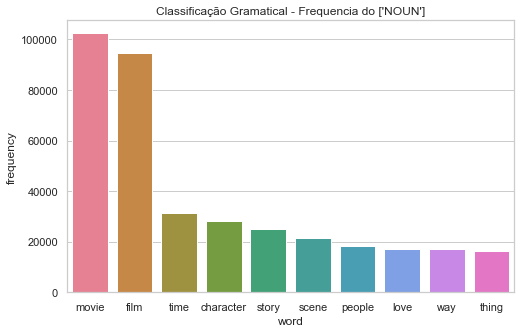

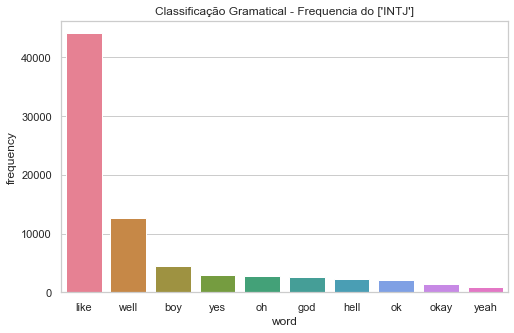

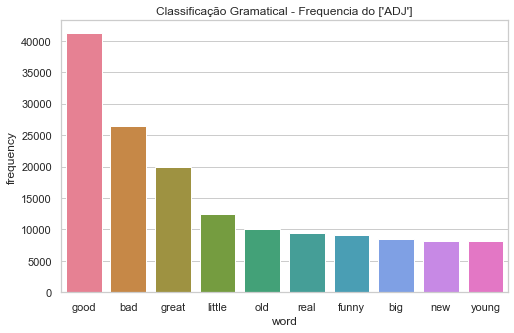

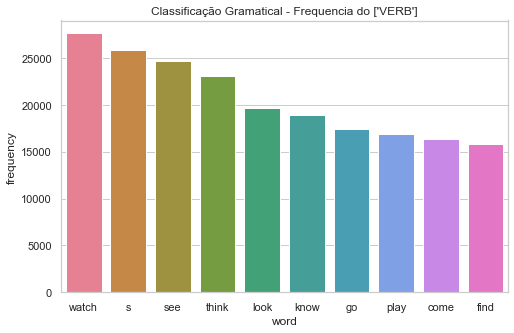

In [31]:
visualizacao01("[\'NOUN\']")
visualizacao01("[\'INTJ\']")
visualizacao01("[\'ADJ\']")
visualizacao01("[\'VERB\']")

Palavras que mais se repetem dentro do dataset

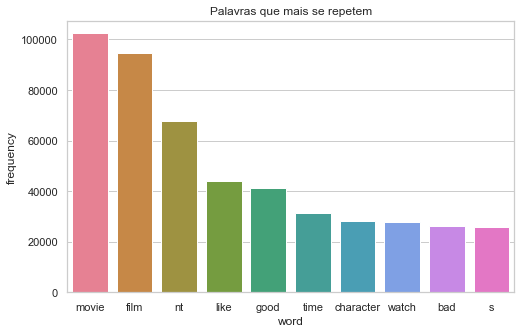

In [32]:
data =  df_word_frequency.nlargest(10, 'frequency')
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8,5))
sns.barplot(x="word",y = "frequency", data = data, palette="husl")
plt.title('Palavras que mais se repetem') 
plt.show()

#### Divisão dos dados em treino e teste

É importante dividir os dados em treino e teste, com o intuito de poder validar os modelos posteriormente.

In [128]:
df_train = pd.read_csv("dataset/df_processado_completo.csv")
X = df_train['text_processed_spacy']
y = df_train['sentiment_cate'].to_numpy()

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42,stratify=y)

#### Vetorização - Bag of words

O modelo bag-of-words é uma representação simplificadora usada no processamento de linguagem natural. Nesse modelo, um texto é representado como a bolsa  de suas palavras, desconsiderando a gramática e até mesmo a ordem das palavras.

><div>
<img src="imgs/bow.png",width=100, height=50>
</div>

In [129]:
vetorizer = CountVectorizer()
X_train = vetorizer.fit_transform(X_train)
X_test = vetorizer.transform(X_test)

O valor tf–idf, é uma medida estatística que tem o intuito de indicar a importância de uma palavra de um documento em relação a uma coleção de documentos ou em um corpus linguístico. Onde quanto mais uma palavra é repetida em um texto menor é sua importancia pra esse texto.

In [34]:
transformer = TfidfTransformer()
X_train = transformer.fit_transform(X_train)
X_test = transformer.transform(X_test)

Função para realizar a vetorização

In [3]:
def vetorizer(X_train,X_test):
    vetorizer = CountVectorizer()
    X_train = vetorizer.fit_transform(X_train)
    X_test = vetorizer.transform(X_test)
    
    transformer = TfidfTransformer()
    X_train = transformer.fit_transform(X_train)
    X_test = transformer.transform(X_test)
    return X_train,X_test    

#### Score
Essa função exibe as metricas de avaliação do modelo. Como o score, recall, f1 score, precisão e kappa. Além disso, ela também exibe a matriz de confusão. 

In [35]:
def score(y_test,y_pred):
    y_score = accuracy_score(y_test,y_pred)
    y_recall = recall_score(y_test,y_pred)
    y_f1_score = f1_score(y_test,y_pred)
    y_precision = precision_score(y_test,y_pred)
    y_kappa = cohen_kappa_score(y_test,y_pred)
    print('Acuracia: ' + str(y_score))
    print('Recall: ' + str(y_recall))
    print('F1 Score: '+ str(y_f1_score))
    print('Precisão: ' + str(y_precision))
    print('Kappa: ' + str(y_kappa))
    
    print('\n')
    
    print('Classification Report')
    print(classification_report(y_test,y_pred,target_names=['neg','pos']))
    
    matrix = metrics.confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,5))
    sns.heatmap(matrix, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = 'Accuracy Score: {0}'.format(y_score)
    plt.title(all_sample_title, size = 15);

### Classificação

A classificação é responsável por atribuir uma classe a um objeto de acordo com suas caracteristicas.Essa classificação pode ser binária (duas classes, 1 ou 0) ou multiclasse (três ou mais classes).

#### Regressão Logistica
A Regressão Logística  é comumente utilizada para estimar a probabilidade de uma instância pertencer a uma determinada classe. Aplica a função sigmoid.

><div>
<img src="imgs/logistica.png",width=100, height=50>
</div>

In [45]:
model_LR = LogisticRegression(solver='lbfgs', max_iter=500,random_state=42)
model_LR = model_LR.fit(X_train, y_train)

In [46]:
pred_LR = model_LR.predict(X_test)

Acuracia: 0.8892
Recall: 0.907
F1 Score: 0.8911377480841031
Precisão: 0.8758207802240248
Kappa: 0.7784


Classification Report
              precision    recall  f1-score   support

         neg       0.90      0.87      0.89      5000
         pos       0.88      0.91      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



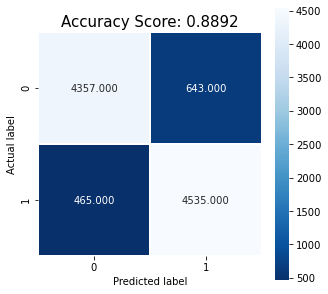

In [47]:
score(y_test,pred_LR)

#### KNN

O KNN realiza a classificação avaliando as caracteristicas dos K vizinhos mais próximos. 
><div>
<img src="imgs/knn.png",width=100, height=50>
</div>

In [80]:
#Instanciando o modelo
knn = KNeighborsClassifier(n_neighbors=100,weights='distance')
#Treinando o modelo
model_knn = knn.fit(X_train,y_train)

In [81]:
#realizando a predição
pred_knn = model_knn.predict(X_test)

Acuracia: 0.8118
Recall: 0.8162
F1 Score: 0.8126244524093987
Precisão: 0.8090800951625694
Kappa: 0.6235999999999999


Classification Report
              precision    recall  f1-score   support

         neg       0.81      0.81      0.81      5000
         pos       0.81      0.82      0.81      5000

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000



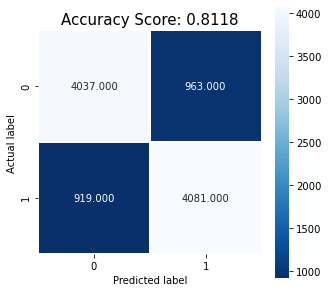

In [82]:
score(y_test,pred_knn)

#### Naive Bayes
O Naive Bayes é baseado na aplicação do teorema de Bayes com suposições de independência fortes entre as características.

In [100]:
naive = MultinomialNB() #bernoulliNB
model_naive = naive.fit(X_train,y_train)

In [101]:
pred_naive = model_naive.predict(X_test)

Acuracia: 0.8643
Recall: 0.8534
F1 Score: 0.8628045698109392
Precisão: 0.8724187282764261
Kappa: 0.7286


Classification Report
              precision    recall  f1-score   support

         neg       0.86      0.88      0.87      5000
         pos       0.87      0.85      0.86      5000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



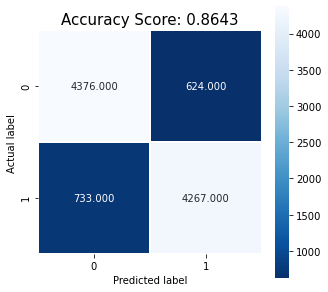

In [102]:
score(y_test,pred_naive)

#### Arvores de decisão
A árvore de decisões é uma técnica utilizada para Classificação e consiste em um mapa dos possíveis resultados de uma série de escolhas. Essas escolhas estão relacionadas a diversas decisões tomadas com base nas variáveis do banco de dados utilizado.

><div>
<img src="imgs/arvore-de-decisão.png",width=100, height=50>
</div>

In [112]:
tree = DecisionTreeClassifier(criterion = 'gini',random_state=42,max_depth=15)
model_tree = tree.fit(X_train, y_train)

In [113]:
pred_tree = model_tree.predict(X_test)

Acuracia: 0.738
Recall: 0.824
F1 Score: 0.7587476979742173
Precisão: 0.7030716723549488
Kappa: 0.476


Classification Report
              precision    recall  f1-score   support

         neg       0.79      0.65      0.71      5000
         pos       0.70      0.82      0.76      5000

    accuracy                           0.74     10000
   macro avg       0.75      0.74      0.74     10000
weighted avg       0.75      0.74      0.74     10000



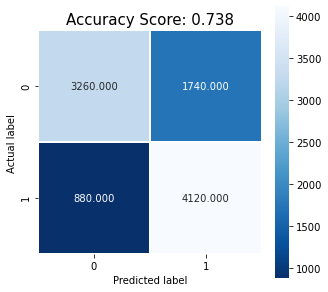

In [114]:
score(y_test,pred_tree)

#### Floresta Aleatória

><div>
<img src="imgs/maxresdefault.jpg",width=100, height=50>
</div>

In [115]:
random_forest = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1,random_state=42)
model_rf = random_forest.fit(X_train, y_train)

In [116]:
pred_rf = model_rf.predict(X_test)

Acuracia: 0.8378
Recall: 0.8686
F1 Score: 0.8426464881645325
Precisão: 0.8181989449886963
Kappa: 0.6756


Classification Report
              precision    recall  f1-score   support

         neg       0.86      0.81      0.83      5000
         pos       0.82      0.87      0.84      5000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



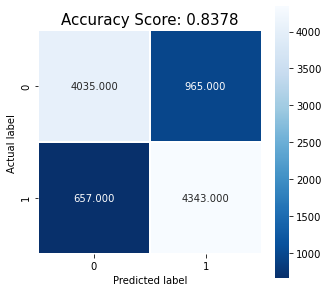

In [117]:
score(y_test,pred_rf)

#### Perceptron
Perceptron é uma rede neural de camada única e um Perceptron de várias camadas é chamado de Rede Neural Artificial. O Perceptron é um classificador linear (binário). Além disso, é usado na aprendizagem supervisionada e pode ser usado para classificar os dados de entrada fornecidos.

><div>
<img src="imgs/perceptron.jpg",width=100, height=50>
</div>

In [118]:
ptn = Perceptron(max_iter=500)                    
model_ptn = ptn.fit(X_train, y_train)                


In [119]:
pred_ptn = model_ptn.predict(X_test) 

Acuracia: 0.8684
Recall: 0.8858
F1 Score: 0.8706506781993317
Precisão: 0.8560108233475068
Kappa: 0.7368


Classification Report
              precision    recall  f1-score   support

         neg       0.88      0.85      0.87      5000
         pos       0.86      0.89      0.87      5000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



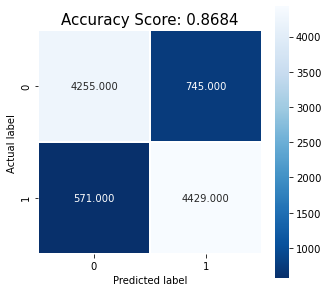

In [120]:
score(y_test,pred_ptn)

#### MLP Classifier

Um MLP consiste em pelo menos três camadas de nós: uma camada de entrada , uma camada oculta e uma camada de saída . Exceto para os nós de entrada, cada nó é um neurônio que usa uma função de ativação não linear 

><div>
<img src="imgs/mlp.png",width=100, height=50>
</div>

In [125]:
mlp = MLPClassifier() 
model_mlp = mlp.fit(X_train, y_train)                 

C:\Users\STEFA\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [126]:
pred_mlp = model_mlp.predict(X_test)

Acuracia: 0.8789
Recall: 0.8888
F1 Score: 0.8800871373403307
Precisão: 0.8715434398901746
Kappa: 0.7578


Classification Report
              precision    recall  f1-score   support

         neg       0.89      0.87      0.88      5000
         pos       0.87      0.89      0.88      5000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



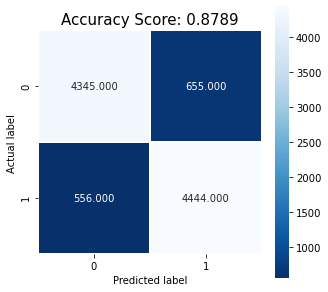

In [127]:
score(y_test,pred_mlp)

#### Ensemble

Tembém pode ser chamado de comite de classificação, uma vez que atribui uma classe a uma instancia de acordo com a votação de vários modelos de classificação.
><div>
<img src="imgs/ensemble.png",width=100, height=50>
</div>

In [26]:
lr_clf = LogisticRegression(solver='lbfgs', max_iter=1000)
naive_clf = MultinomialNB()
rf_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1,random_state=42)

In [27]:
voting_clf = VotingClassifier(
 estimators=[('lr', lr_clf), ('naive', naive_clf), ('rf', rf_clf)],
 voting='hard')

In [28]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(max_iter=1000)),
                             ('naive', MultinomialNB()),
                             ('rf',
                              RandomForestClassifier(max_leaf_nodes=16,
                                                     n_estimators=500,
                                                     n_jobs=-1,
                                                     random_state=42))])

In [29]:
pred_clf = voting_clf.predict(X_test) 

Acuracia: 0.8801
Recall: 0.8918
F1 Score: 0.8814866067015914
Precisão: 0.8714090287277702


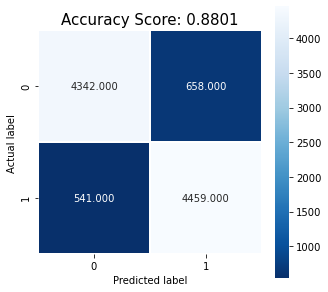

In [30]:
score(y_test,pred_clf)

In [31]:
for clf in (lr_clf, naive_clf, rf_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.8892
MultinomialNB 0.8643
RandomForestClassifier 0.8378
VotingClassifier 0.8801


#### Bagging
Realiza a votação de um conjunto de previsores mas cada previsor é composto do mesmo modelo de classificação. Os dados de treinamento são divididos em conjuntos aleatorios para cada previsor.

In [32]:
rf_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1,random_state=42)
bag_clf = BaggingClassifier(rf_clf)
bag_clf.fit(X_train, y_train)
pred_bag = bag_clf.predict(X_test)

Acuracia: 0.8801
Recall: 0.8918
F1 Score: 0.8814866067015914
Precisão: 0.8714090287277702


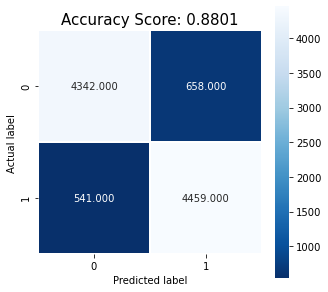

In [33]:
score(y_test,y_pred)

#### K-fold

O método de validação cruzada denominado k-fold consiste em dividir o conjunto total de dados em k subconjuntos mutuamente exclusivos do mesmo tamanho e, a partir daí, um subconjunto é utilizado para teste e os k-1 restantes são utilizados para estimação dos parâmetros, fazendo-se o cálculo da acurácia do modelo.

In [5]:
df_train = pd.read_csv("dataset/df_processado_completo.csv")
X = df_train['text_processed_spacy']
y = df_train['sentiment_cate'].to_numpy()

Vetorização

In [6]:
vetorizer = CountVectorizer()
X_vetorizer = vetorizer.fit_transform(X)

transformer = TfidfTransformer()
X_vetorizer = transformer.fit_transform(X_vetorizer)



In [10]:
def get_kfold(x,y,k,model):
    kfold = KFold(n_splits=k, shuffle=True)
    result = cross_val_score(model,x , y, cv = kfold)    
    return result.mean()

In [8]:
kfold = KFold(n_splits=2, shuffle=True)
for train_idx, test_idx in kfold.split(X, y):
    print("TRAIN:", train_idx, "\nTEST:", test_idx)

TRAIN: [    0     2     5 ... 49991 49992 49996] 
TEST: [    1     3     4 ... 49997 49998 49999]
TRAIN: [    1     3     4 ... 49997 49998 49999] 
TEST: [    0     2     5 ... 49991 49992 49996]


In [12]:
#lr2 = lm.LinearRegression() 
#kfold = [get_kfold(X_vetorizer, y, i, lr2) for i in range(2,4,1)]

Text(0, 0.5, 'Score')

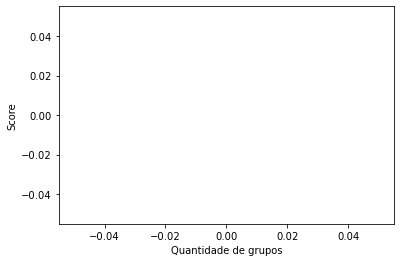

In [66]:
plt.plot(list(range(2,11,1)), kfold)
plt.xlabel("Quantidade de grupos")
plt.ylabel("Score")